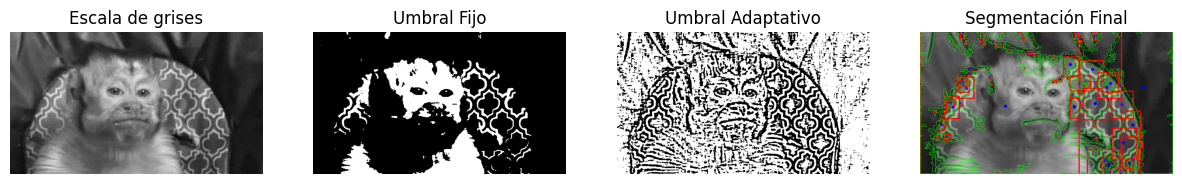

Formas detectadas: 172
Área promedio: 1052.55
Perímetro promedio: 113.94
Presiona 'q' para salir.


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Carga la imagen en escala de grises desde la ruta dada
def cargar_imagen(ruta):
    imagen = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
    if imagen is None:
        raise FileNotFoundError("No se encontró la imagen en la ruta especificada.")
    return imagen

# Aplica umbral fijo y umbral adaptativo para segmentar la imagen
def aplicar_umbralizaciones(imagen):
    _, fijo = cv2.threshold(imagen, 128, 255, cv2.THRESH_BINARY)  # Umbral fijo: blanco o negro
    adapt = cv2.adaptiveThreshold(imagen, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY, 11, 2)        # Umbral adaptativo: depende del vecindario
    return fijo, adapt

# Encuentra contornos, calcula áreas y perímetros de cada forma detectada
def detectar_formas(binaria):
    contornos, _ = cv2.findContours(binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contornos]
    perimetros = [cv2.arcLength(c, True) for c in contornos]
    return contornos, areas, perimetros

# Dibuja contornos, centros y rectángulos envolventes sobre la imagen original
def dibujar_resultados(gris, contornos):
    resultado = cv2.cvtColor(gris, cv2.COLOR_GRAY2BGR)  # Convierte a BGR para dibujar en color
    for c in contornos:
        M = cv2.moments(c)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])  # Coordenada X del centroide
            cy = int(M["m01"] / M["m00"])  # Coordenada Y del centroide
            cv2.circle(resultado, (cx, cy), 4, (0, 0, 255), -1)  # Punto rojo en el centro

        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(resultado, (x, y), (x+w, y+h), (255, 0, 0), 2)  # Rectángulo azul

    cv2.drawContours(resultado, contornos, -1, (0, 255, 0), 1)  # Dibuja todos los contornos en verde
    return resultado

# Muestra múltiples imágenes en una sola ventana usando Matplotlib
def mostrar_imagenes(titulos_imgs):
    plt.figure(figsize=(15, 5))
    for i, (img, titulo) in enumerate(titulos_imgs):
        cmap = 'gray' if len(img.shape) == 2 else None
        plt.subplot(1, len(titulos_imgs), i + 1)
        plt.imshow(img, cmap=cmap)
        plt.title(titulo)
        plt.axis('off')
    plt.show()

# Versión en vivo con cámara: segmentación y contornos en tiempo real
def segmentar_webcam():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("No se pudo acceder a la cámara.")
        return

    print("Presiona 'q' para salir.")
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        adapt = cv2.adaptiveThreshold(gris, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                      cv2.THRESH_BINARY, 11, 2)
        contornos, _, _ = detectar_formas(adapt)
        resultado = dibujar_resultados(gris, contornos)

        cv2.imshow("Segmentacion Webcam", resultado)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Ejecución del flujo principal con imagen estática
img_gris = cargar_imagen('../datos/monito.jpg')                            # Carga imagen
umbral_fijo, umbral_adapt = aplicar_umbralizaciones(img_gris)     # Segmenta por umbral

contornos, areas, perimetros = detectar_formas(umbral_adapt)      # Encuentra formas
resultado = dibujar_resultados(img_gris, contornos)               # Visualiza resultados

mostrar_imagenes([
    (img_gris, "Escala de grises"),
    (umbral_fijo, "Umbral Fijo"),
    (umbral_adapt, "Umbral Adaptativo"),
    (resultado, "Segmentación Final")
])

# Estadísticas simples de las formas encontradas
print(f"Formas detectadas: {len(contornos)}")
if areas:
    print(f"Área promedio: {np.mean(areas):.2f}")
    print(f"Perímetro promedio: {np.mean(perimetros):.2f}")

segmentar_webcam()
